In [64]:
from loica import *
import matplotlib.pyplot as plt
import numpy as np
import getpass

In [65]:
from numpy.fft import fft, ifft, fftfreq
from scipy.interpolate import interp1d, UnivariateSpline

def random_profile(t0, tmax, nt, fmax):
    freqs = fftfreq(nt)
    tff = np.zeros((nt,), dtype=np.complex)
    ncomps = len(freqs[np.abs(freqs)<fmax])
    tff[np.abs(freqs)<fmax] = np.random.normal(size=(ncomps,)) + np.random.normal(size=(ncomps,))*1j
    profile = ifft(tff).real
    profile = (profile - profile.min()) / (profile.max() - profile.min())
    t = np.linspace(t0, tmax, nt)
    return interp1d(t, profile)

def spline_profile(t0, tmax, nst):
    st = np.linspace(t0, tmax, nst)
    y = np.random.uniform(size=st.shape)
    profile = UnivariateSpline(st, y-y.min(), s=0)
    return profile

def gaussian_profile(t0, tmax, nt, n_blobs):
    t = np.linspace(t0, tmax, nt)
    profile = np.zeros_like(t)
    means = np.linspace(t.min(), t.max(), n_blobs)
    vars = [t.max()/n_blobs]*n_blobs #res.x[:n_blobs]
    heights = np.random.lognormal(size=(n_blobs,))
    for mean,var,height in zip(means, vars, heights):
        gaussian = height * np.exp(-(t-mean)*(t-mean) / var / 2) / np.sqrt(2 * np.pi * var)
        profile += gaussian
    return interp1d(t, profile/profile.max())

In [67]:
from flapjack import *
fj = Flapjack(url_base='flapjack.rudge-lab.org:8000')
#fj = Flapjack(url_base='localhost:8000')
fj.log_in(username=input('Flapjack username: '), password=getpass.getpass('Password: '))

Flapjack username: Gonza10V
Password: ········


In [68]:
study = fj.get('study', name='Loica testing')
if len(study):
    fj.delete('study', study.id[0])

If you are sure you want to delete study with id=60 type "yes"yes


### Constitutive gene

In [69]:
dna = fj.get('dna', name='Const_1e-3_nsr_blob')
if len(dna)==0:
    dna = fj.create('dna', name='Const_1e-3_nsr_blob')
vector = fj.get('vector', name='Const_1e-3_nsr_blob')    
if len(vector)==0:
    vector = fj.create('vector', name='Const_1e-3_nsr_blob', dnas=dna.id)
    
const = GeneticNetwork(vector=vector.id[0])

In [70]:
sfp1 = fj.get('signal', name='SFP0')
sfp1 = Reporter(name='CFP', degradation_rate=0, init_concentration=0, signal_id=sfp1.id[0])

const.add_reporter(sfp1)

In [71]:
#def profile(t):
#    return 1 - gompertz_growth_rate(t, 0.01, 1, 1, 4)
#profile = random_profile(t0=0, tmax=24, nt=100, fmax=0.025)
#profile = spline_profile(t0=0, tmax=24, nst=20)
profile = gaussian_profile(t0=0, tmax=24, nt=100, n_blobs=20)
const.add_operator(Source(output=sfp1, rate=1, profile=profile))

100


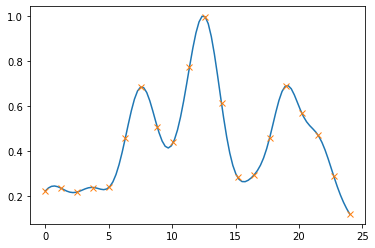

In [72]:
t = np.linspace(0, 24, 100)
plt.plot(t, profile(t))
st = np.linspace(0, 24, 20)
plt.plot(st, profile(st), 'x')
print(len(profile(t)))

In [73]:
print(profile(t))

[0.22398815 0.23759934 0.24498187 0.2466132  0.24364658 0.23768607
 0.23052457 0.22388525 0.21918726 0.21734755 0.21863744 0.22262685
 0.22825492 0.23405038 0.23848706 0.24041011 0.23943055 0.23617764
 0.23233061 0.23041211 0.23339092 0.24418439 0.26515637 0.29768017
 0.34180191 0.39602232 0.45722671 0.52081976 0.58113119 0.63212047
 0.66831677 0.68581837 0.68309992 0.66138947 0.62448987 0.57809131
 0.5287787  0.48301183 0.44632328 0.42286494 0.41529729 0.42491337
 0.45184947 0.49525395 0.55334    0.62331535 0.70124561 0.78196163
 0.85914991 0.92575002 0.97470723 1.         0.99772336 0.96692811
 0.90994414 0.83206067 0.74063833 0.6438995  0.54970971 0.46460881
 0.39322127 0.33804426 0.29953798 0.27643658 0.26622894 0.26577948
 0.27204034 0.28275013 0.29695676 0.31518523 0.33912876 0.37087106
 0.41181459 0.46163218 0.51761495 0.57471471 0.62637896 0.66600684
 0.68861198 0.692163   0.67814456 0.6511281  0.61747345 0.58357493
 0.55420737 0.53147061 0.51460686 0.50066423 0.48571394 0.4661

In [74]:
def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 0.5)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 0.5)
    
#od = fj.get('signal', name='OD')
#const_study = fj.get('study', name=['Context effects'])
#vector = fj.get('vector', name='pAAA')
#print(vector)
#media = fj.get('media', name='M9-glucosa')
#print(media)
#strain = fj.get('strain', name='Top10')
#print(strain)

metab = SimulatedMetabolism(biomass, growth_rate)
#metab = DataMetabolism(fj, media, strain, vector, od)

In [75]:
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

samples = []
for i in range(5):
    sample = Sample(circuit=const, 
                    metabolism=metab,
                    media=media.id[0],
                    strain=strain.id[0])
    samples.append(sample)

In [76]:
print(sample.biomass)

<function biomass at 0x7fa8f342a8b0>


In [77]:
biomass_signal = fj.get('signal', name='OD')
print(biomass_signal)
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.24,
              name='Loica constitutive expression (no noise)',
              description='Simulated constitutive gene generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(nsr=1e-3)

   id name description  color
0   5   OD   OD600:600  black


<AxesSubplot:xlabel='Time'>

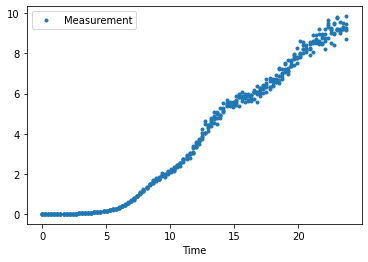

In [78]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', style='.', ax=ax)

In [79]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Testing')
assay.upload(fj, study.id[0])

In [80]:
vector = fj.get('vector', name='Const_1e-3_nsr_blob')
media = fj.get('media', name='Loica')
strain = fj.get('strain', name='Loica strain')
cfp = fj.get('signal', name='SFP0')
biomass_signal = fj.get('signal', name='OD')
print(biomass_signal)

source = Source(None, 0) #const.operators[0]
source.characterize(
    fj,
    vector=vector.id,
    media=media.id,
    strain=strain.id,
    signal=cfp.id,
    biomass_signal=biomass_signal.id,
    n_gaussians=20,
    epsilon=0
)

   id name description  color
0   5   OD   OD600:600  black


100%|██████████| 100/100 [00:00<00:00, 266.10it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 313.37it/s]


Returning dataframe


In [81]:
er_indirect = fj.analysis(media=media.id, 
                    strain=strain.id,
                    vector=[vector.id[0]],
                    type='Expression Rate (indirect)',
                    biomass_signal=biomass_signal.id,
                    eps_L=1e-6,
                    pre_smoothing=11,
                    post_smoothing=11,
                    #bg_correction=2,
                    #min_biomass=0.05,
                    #remove_data=False
                      )
er_direct = fj.analysis(media=media.id, 
                    strain=strain.id,
                    vector=[vector.id[0]],
                    type='Expression Rate (direct)',
                    biomass_signal=biomass_signal.id,
                    eps_L=1e-6,
                    pre_smoothing=11,
                    post_smoothing=11,
                    #bg_correction=2,
                    #min_biomass=0.05,
                    #remove_data=False
                      )

100%|██████████| 100/100 [00:00<00:00, 211.08it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 147.10it/s]

Returning dataframe


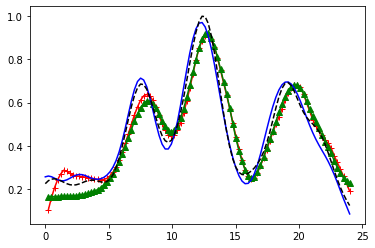

In [82]:
indirect = er_indirect[er_indirect.Signal=='SFP0'].groupby('Time').Rate.mean().values
direct = er_direct[er_direct.Signal=='SFP0'].groupby('Time').Rate.mean().values
plt.plot(t[1:], indirect / 0.24, 'r-+')
plt.plot(t[1:], direct, 'g^-')
plt.plot(t, source.profile(t)*source.rate, 'b')
plt.plot(t, profile(t)/profile(t).max(), 'k--')

In [90]:
LOICA_profile = source.profile(t)*source.rate
true_profile = profile(t)/profile(t).max()

In [ ]:
from sklearn.metrics import mean_squared_error

In [92]:
# mean_squared_error(y_true, y_pred)
mean_squared_error(true_profile[1:], indirect)

0.14950049911833507

In [93]:
mean_squared_error(true_profile[1:], direct)

0.005102623920362069

In [94]:
mean_squared_error(true_profile[1:], LOICA_profile[1:])

0.0010358159488560244

In [85]:
mean_squared_error(y_true, y_pred)

Processing /Users/gonzalovidal/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897/sklearn-0.0-py2.py3-none-any.whl
     |████████████████████████████████| 7.2 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 68.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Receiver

Create a genetic network and associate it with a Flapjack vector:

In [20]:
dna = fj.get('dna', name='Rec_1e-3_nsr')
if len(dna)==0:
    dna = fj.create('dna', name='Rec_1e-3_nsr')
vector = fj.get('vector', name='Rec_1e-3_nsr')    
if len(vector)==0:
    vector = fj.create('vector', name='Rec_1e-3_nsr', dnas=dna.id)
    
rec = GeneticNetwork(vector=vector.id[0])

Create a reporter and associate it with a Flapjack signal so we can record the behaviour of the circuit:

In [21]:
cfp = fj.get('signal', name='CFP')
sfp1 = Reporter(name='CFP', degradation_rate=0, init_concentration=1, signal_id=cfp.id[0])

rec.add_reporter(sfp1)

Create and add a receiver operator to the circuit, linking it to an AHL supplement:

In [22]:
ahl = Supplement(name='AHL')
def sin_profile(t):
    return 1 - np.cos(2 * np.pi * t / 12)
def mu_profile(t):
    return 1 - gompertz_growth_rate(t, 0.01, 1, 1, 4)
rec_profile = random_profile(t0=0, tmax=24, nt=100, fmax=0.05)
rec.add_operator(Receiver(inducer=ahl, output=sfp1, a=0, b=100, K=1, n=2, profile=rec_profile))

Now we have constructed the circuit we need to run an assay containing some samples. The sample is driven by a metabolism which defines the dynamics of growth and gene expression profiles:

In [23]:
def growth_rate(t):
    return gompertz_growth_rate(t, 0.05, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.05, 1, 1, 1)
    
metab = SimulatedMetabolism(biomass, growth_rate)

Next we create a set of samples associated to Flapjack media and strain, and containing our AHL at different concentrations

In [24]:
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

# Create list of samples    
samples = []
for conc in np.logspace(-6, 6, 12):
    sample = Sample(circuit=rec, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0])
    # Add AHL to samples at given concentration
    sample.add_supplement(ahl, conc)
    samples.append(sample)

Now we can create and run the assay:

In [25]:
biomass_signal = fj.get('signal', name='OD')
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.24,
              name='Loica receiver',
              description='Simulated receiver generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(nsr=1e-3)

Plot the results:

2400

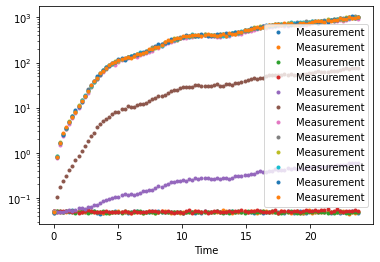

In [26]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].groupby('Sample').plot(x='Time', y='Measurement', style='.', ax=ax)
plt.yscale('log')
len(m)

Upload the simulated data to flapjack

In [27]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')

assay.upload(fj, study.id[0])

In [28]:
#vector = fj.get('vector', name='pREC')
#media = fj.get('media', name='Simulated media')
#strain = fj.get('strain', name='Simulated strain')
#signal = fj.get('signal', name='CFP')
#biomass_signal = fj.get('signal', name='OD')
#print(biomass_signal)

signal = fj.get('signal', name='CFP')
vector = fj.get('vector', name='Rec_1e-3_nsr')
media = fj.get('media', name='Loica')
strain = fj.get('strain', name='Loica strain')
cfp = fj.get('signal', name='CFP')
biomass_signal = fj.get('signal', name='OD')
analyte = fj.get('chemical', name='AHL')

char_receiver = Receiver(None, None, 0,0,0,0)
char_receiver.characterize(
    fj,
    vector=vector.id,
    media=media.id,
    strain=strain.id,
    signal=signal.id,
    biomass_signal=biomass_signal.id,
    n_gaussians=20,
    epsilon=0
)

100%|██████████| 100/100 [00:00<00:00, 101.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.23it/s]


Returning dataframe


a = 0
b =  111.17662437643227
K =  0.9734567603510491
n =  2.048146065900428


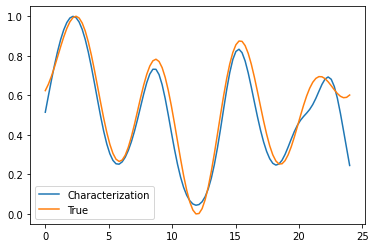

In [29]:
t = np.linspace(0, 24, 100)
print(f'a = {char_receiver.a}')
print('b = ', char_receiver.b)
print('K = ', char_receiver.K)
print('n = ', char_receiver.n)

plt.plot(t, char_receiver.profile(t))
plt.plot(t, rec_profile(t))
plt.legend(['Characterization', 'True'])

### Inverter

In [30]:
dna = fj.get('dna', name='Inv_1e-3_nsr')
if len(dna)==0:
    dna = fj.create('dna', name='Inv_1e-3_nsr')
vector = fj.get('vector', name='Inv_1e-3_nsr')    
if len(vector)==0:
    vector = fj.create('vector', name='Inv_1e-3_nsr', dnas=dna.id)
    
inv = GeneticNetwork(vector=vector.id[0])

In [31]:
def mu_profile(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)
inv_profile = random_profile(t0=0, tmax=24, nt=100, fmax=0.05)

In [32]:
ahl = Supplement(name='AHL')
laci = Regulator('LacI', degradation_rate=2)
rec = Receiver(inducer=ahl, output=laci, a=0, b=100, K=1, n=2, profile=rec_profile)
inv.add_operator(rec)
inv.add_regulator(laci)

In [33]:
cfp = fj.get('signal', name='CFP')
cfp = Reporter('CFP', signal_id=cfp.id[0])
inv.add_reporter(cfp)
inv.add_operator(Not(input=laci, output=cfp, a=100, b=0, K=1, n=2, profile=inv_profile))

In [34]:
# Create list of samples    
samples = []
media = fj.get('media', name='Loica')
strain = fj.get('strain', name='Loica strain')
for conc in np.logspace(-6, 6, 12):
    sample = Sample(circuit=inv, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0])
    # Add AHL to samples at given concentration
    sample.add_supplement(ahl, conc)
    samples.append(sample)

In [35]:
biomass_signal = fj.get('signal', name='OD')
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.24,
              name='Loica inverter',
              description='Simulated inverter generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

<AxesSubplot:xlabel='Time'>

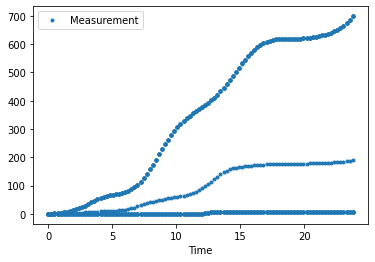

In [36]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', style='.', ax=ax)

In [37]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')

assay.upload(fj, study.id[0])

In [38]:
signal = fj.get('signal', name='CFP')
receiver = fj.get('vector', name='Rec_1e-3_nsr')
inverter = fj.get('vector', name='Inv_1e-3_nsr')
media = fj.get('media', name='Loica')
strain = fj.get('strain', name='Loica strain')
biomass_signal = fj.get('signal', name='OD')
analyte = fj.get('chemical', name='AHL')

char_not = Not(input=None, output=None, a=100, b=0, K=1, n=2)
char_not.characterize(
    fj,
    receiver = receiver.id,
    inverter=inverter.id,
    media=media.id,
    strain=strain.id,
    signal=signal.id,
    biomass_signal=biomass_signal.id,
    n_gaussians=20,
    epsilon=0,
    gamma=2
)

100%|██████████| 100/100 [00:01<00:00, 81.79it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 82.33it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 81.60it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.76it/s]


Returning dataframe


0 111.17662437643227 0.9734567603510491 2.048146065900428
107.99127340737529 0.0002031837777522441 0.8877194879552331 1.6559168805372488


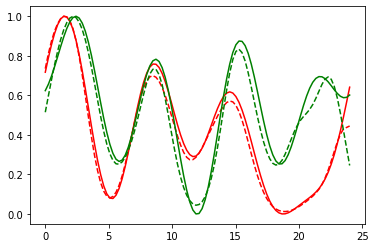

In [39]:
t = np.linspace(0, 24, 100)
plt.plot(t, char_not.profile(t), 'r--')
plt.plot(t, inv_profile(t), 'r')
plt.plot(t, rec_profile(t), 'g')
plt.plot(t, char_not.profile_A(t), 'g--')

print(char_not.a_A, char_not.b_A, char_not.K_A, char_not.n_A)
print(char_not.a, char_not.b, char_not.K, char_not.n) #, char_not.gamma)

[0.03385883 0.00908415 0.00062634]
1.6559168805372488 0.8877194879552331 0.0002031837777522441


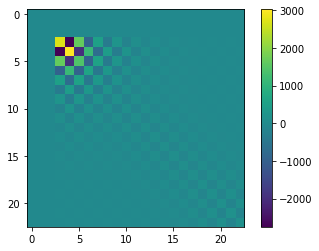

In [40]:
J = char_not.res.jac
H = J.T.dot(J)
C = np.linalg.inv(H) * np.sum(char_not.res.fun*char_not.res.fun) / 100
covar = np.diag(np.abs(C))
std = np.sqrt(covar)
print(std[:3])
print(char_not.n, char_not.K, char_not.b)
plt.imshow(C[:,:]); plt.colorbar()

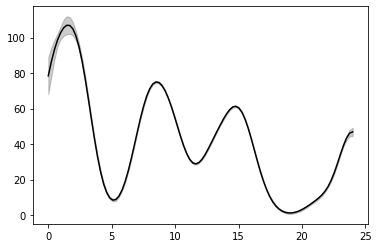

In [41]:
means = np.linspace(t.min(), t.max(), 20)
vars = [t.max()/20]*20 #res.x[:n_blobs]

profiles = []
for i in range(1000):
    rheights = np.random.multivariate_normal(char_not.res.x[3:], C[3:,3:])
    profile = np.zeros_like(t)
    for mean,var,height in zip(means, vars, rheights):
        gaussian = height * np.exp(-(t-mean)*(t-mean) / var / 2) / np.sqrt(2 * np.pi * var)
        profile += gaussian
    profiles.append(np.array(profile))
profiles = np.array(profiles)
mean = np.mean(profiles, axis=0)
std = np.std(profiles, axis=0)
plt.plot(t, mean, 'k')
plt.fill_between(t, mean-std, mean+std, color='k', alpha=0.2)

### Repressilator

In [42]:
dna = fj.get('dna', name='Rep')
if len(dna)==0:
    dna = fj.create('dna', name='Rep')
vector = fj.get('vector', name='Rep')    
if len(vector)==0:
    vector = fj.create('vector', name='Rep', dnas=dna.id)
    
rep = GeneticNetwork(vector=vector.id[0])

In [43]:
laci = Regulator(name='LacI', degradation_rate=1, init_concentration=5)
tetr = Regulator(name='TetR', degradation_rate=1)
ci = Regulator(name='cI', degradation_rate=1)
rep.add_regulator(laci)
rep.add_regulator(tetr)
rep.add_regulator(ci)

cfp = fj.get('signal', name='CFP')
yfp = fj.get('signal', name='YFP')
rfp = fj.get('signal', name='RFP')

sfp1 = Reporter(name='CFP', degradation_rate=1, signal_id=cfp.id[0])
rep.add_reporter(sfp1)
sfp2 = Reporter(name='YFP', degradation_rate=1, signal_id=yfp.id[0])
rep.add_reporter(sfp2)
sfp3 = Reporter(name='RFP', degradation_rate=1, signal_id=rfp.id[0])
rep.add_reporter(sfp3)

rep.add_operator(Not(input=ci, output=laci, a=100, b=0, K=1, n=2))
rep.add_operator(Not(input=laci, output=tetr, a=100, b=0, K=1, n=2))
rep.add_operator(Not(input=tetr, output=ci, a=100, b=0, K=1, n=2))

rep.add_operator(Not(input=ci, output=sfp1, a=100, b=0, K=1, n=2))
rep.add_operator(Not(input=laci, output=sfp2, a=100, b=0, K=1, n=2))
rep.add_operator(Not(input=tetr, output=sfp3, a=100, b=0, K=1, n=2))

In [44]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

biomass_signal = fj.get('signal', name='OD')

sample = Sample(circuit=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='Loica repressilator',
              description='Simulated repressilator generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

In [45]:
assay.measurements

,Measurement,Sample,Signal,Signal_id,Time
0,0.000000,0.0,CFP,6.0,0.00
1,0.000000,0.0,YFP,7.0,0.00
2,0.000000,0.0,RFP,8.0,0.00
3,0.050178,0.0,Biomass,5.0,0.00
4,0.124263,0.0,CFP,6.0,0.25
...,...,...,...,...,...
395,1.000000,0.0,Biomass,5.0,24.50
396,5.429105,0.0,CFP,6.0,24.75
397,6.959670,0.0,YFP,7.0,24.75
398,2.996218,0.0,RFP,8.0,24.75


<AxesSubplot:xlabel='Time'>

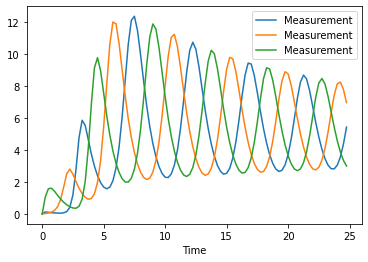

In [46]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', ax=ax)
m[m.Signal=='YFP'].plot(x='Time', y='Measurement', ax=ax)
m[m.Signal=='RFP'].plot(x='Time', y='Measurement', ax=ax)

Upload simulated data to flapjack

In [47]:
assay.upload(fj, study.id[0])

### Toggle switch

In [48]:
dna = fj.create('dna', name='Toggle')
vector = fj.create('vector', name='Toggle', dnas=dna.id)
tog = GeneticNetwork(vector=vector.id[0])

laci = Regulator(name='LacI', degradation_rate=1, init_concentration=0.1)
ci = Regulator(name='cI', degradation_rate=1)
tog.add_regulator(laci)
tog.add_regulator(ci)

cfp = fj.get('signal', name='CFP')
yfp = fj.get('signal', name='YFP')
sfp1 = Reporter(name='CFP', degradation_rate=1, signal_id=cfp.id[0])
tog.add_reporter(sfp1)
sfp2 = Reporter(name='YFP', degradation_rate=1, signal_id=yfp.id[0])
tog.add_reporter(sfp2)

tog.add_operator(Not(input=laci, output=ci, a=10, b=0, K=1, n=2))
tog.add_operator(Not(input=ci, output=laci, a=10, b=0, K=1, n=2))

tog.add_operator(Not(input=ci, output=sfp1, a=10, b=0, K=1, n=2))
tog.add_operator(Not(input=laci, output=sfp2, a=10, b=0, K=1, n=2))

In [49]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

biomass_signal = fj.get('signal', name='OD')
sample = Sample(circuit=tog, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='Loica toggle',
              description='Simulated toggle switch generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

<AxesSubplot:xlabel='Time'>

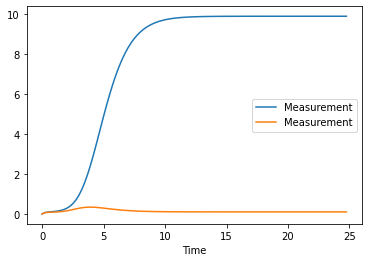

In [50]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', ax=ax)
m[m.Signal=='YFP'].plot(x='Time', y='Measurement', ax=ax)

Upload simulated data to flapjack

In [51]:
assay.upload(fj, study.id[0])

### Nor gate

In [52]:
dna = fj.get('dna', name='Nor')
if len(dna)==0:
    dna = fj.create('dna', name='Nor')
vector = fj.get('vector', name='Nor')    
if len(vector)==0:
    vector = fj.create('vector', name='Nor', dnas=dna.id)
    
nor = GeneticNetwork(vector=vector.id[0])

Create a reporter and associate it with a Flapjack signal so we can record the behaviour of the circuit:

In [53]:
cfp = fj.get('signal', name='CFP')
sfp1 = Reporter(name='CFP', degradation_rate=0, signal_id=cfp.id[0])

nor.add_reporter(sfp1)

Create and add a receiver operator to the circuit, linking it to an AHL supplement and the receptor we just created:

In [54]:
ahl1 = Supplement(name='AHL1')
ahl2 = Supplement(name='AHL2')
nor.add_operator(Nor(input=[ahl1, ahl2], output=sfp1, alpha=[0.0001,1,1,1], a=[100,100], b=[1,1], K=[1,1], n=[2,2]))

Now we have constructed the circuit we need to run an assay containing some samples. The sample is driven by a metabolism which defines the dynamics of growth and gene expression profiles:

In [55]:
def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 4)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 4)
    
metab = SimulatedMetabolism(biomass, growth_rate)

Next we create a set of samples associated to Flapjack media and strain, and containing our AHL at different concentrations

In [56]:
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

# Create list of samples    
samples = []
for conc1 in np.logspace(-3, 3, 6):
    for conc2 in np.logspace(-3,3,6):
        sample = Sample(circuit=nor, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0])
        # Add AHL to samples at given concentration
        sample.add_supplement(ahl1, conc1)
        sample.add_supplement(ahl2, conc2)
        samples.append(sample)

Now we can create and run the assay:

In [57]:
biomass_signal = fj.get('signal', name='OD')
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.25,
              name='Loica nor',
              description='Simulated nor generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

Plot the results:

<AxesSubplot:xlabel='Time'>

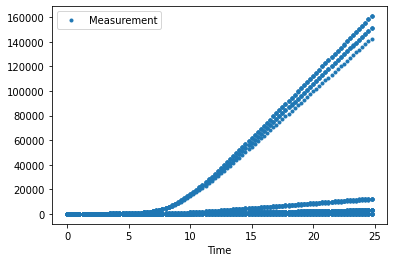

In [58]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', style='.', ax=ax)

Upload the simulated data to flapjack

In [59]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')

assay.upload(fj, study.id[0])